Load the pairwise language distances.

In [1]:
pairwise_language_distances = read.csv("language_distances.csv")

***
Import the language data again.

In [2]:
library(tidyverse)
geodata = read_tsv("northeuralex-0.9-language-data.tsv", show_col_types = FALSE)
head(geodata)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.1 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


name,glotto_code,iso_code,family,subfamily,latitude,longitude
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
Finnish,finn1318,fin,Uralic,Finnic,61.0000,24.4500
North Karelian,kare1335,krl,Uralic,Finnic,65.1691,30.8655
Olonets Karelian,livv1243,olo,Uralic,Finnic,61.0000,33.0000
Veps,veps1250,vep,Uralic,Finnic,60.3353,34.7865
Estonian,esto1258,ekk,Uralic,Finnic,59.2500,24.7500
Livonian,livv1244,liv,Uralic,Finnic,57.5660,22.0262


***
Apply multi-dimensional scaling on the pairwise distances.

In [8]:
multi_dimensional_scaling = cmdscale(pairwise_language_distances, add = TRUE, k=3) %>%
  as_tibble()
head(multi_dimensional_scaling)

ERROR: [1m[33mError[39m:[22m
[33m![39m All columns in a tibble must be vectors.
[31m✖[39m Column `eig` is NULL.
[31m✖[39m Column `x` is NULL.


***
Scale the three dimensions between 0 and 1 to assign each language value for red, green and blue.

In [4]:
iso_codes = geodata %>% select(iso_code)

mds = 
  as_tibble(multi_dimensional_scaling) %>%
  mutate(iso_codes = iso_codes$iso_code) %>%
  # subtract the smallest value
  mutate(x = V1 - min(.$V1), y = V2 - min(.$V2), z = V3 - min(.$V3)) %>%
  # divide by maximum value
  mutate(r = x / max(.$x), g = y / max(.$y), b = z / max(.$z)) %>%
  # combine r, g, and b into a color
  mutate(col = rgb(r,g,b)) %>%
  # select the only two relevant columns
  select(iso_codes, col, r, g, b) 

head(mds)

iso_codes,col,r,g,b
<chr>,<chr>,<dbl>,<dbl>,<dbl>
fin,#D3A98D,0.8285287,0.6637814,0.5543358
krl,#D5BB91,0.8364474,0.7320759,0.5678098
olo,#DDBA8B,0.8661032,0.7289159,0.5436632
vep,#DBBC9E,0.8590097,0.7379964,0.6196270
ekk,#E0BAA3,0.8776142,0.7278977,0.6393278
liv,#E0C5AE,0.8773875,0.7741414,0.6830394


Joining, by = "iso_codes"
To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`

Linking to GEOS 3.9.3, GDAL 3.5.2, PROJ 8.2.1; sf_use_s2() is TRUE

Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"


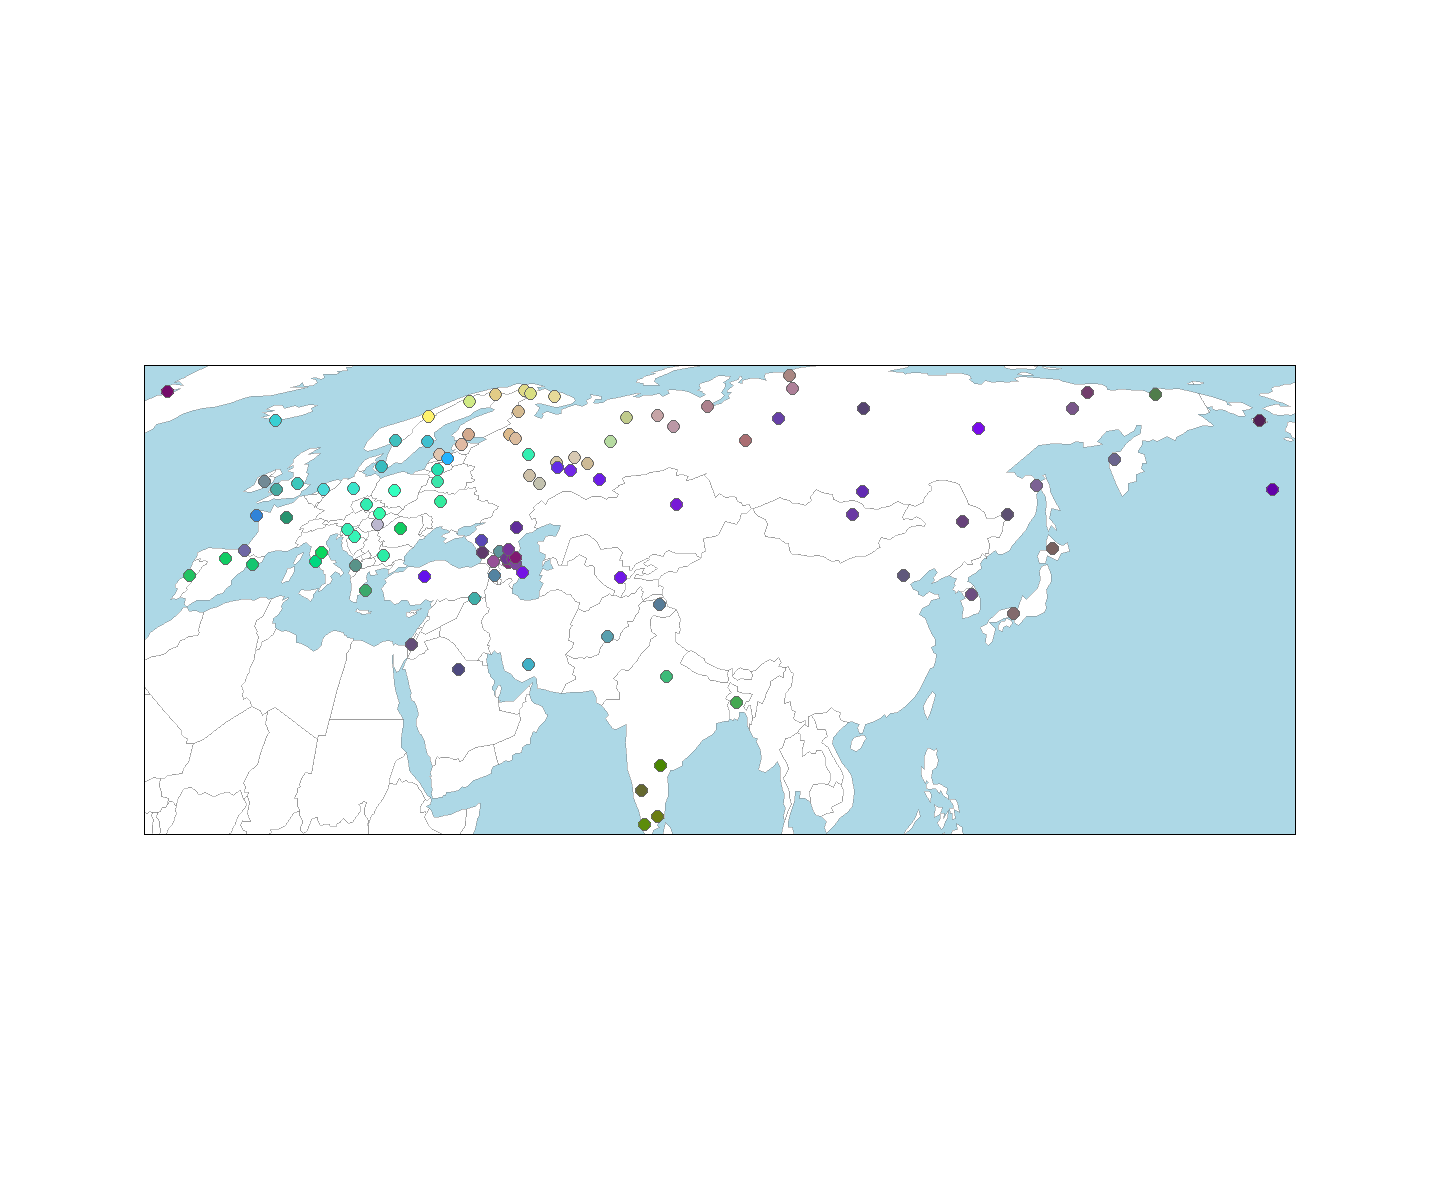

In [5]:
# join coordinates with the color data 
colored_geodata = geodata %>% 
  rename(iso_codes = iso_code) %>%
  select(iso_codes, latitude, longitude, family, subfamily) %>%
  inner_join(mds)

library(spData)
library(sf)

# produce an extremely slim polygon that represents the 60° W meridian
meridian_55_west = 
  st_polygon(x = list(rbind(c(-55.0001, 90), # upper left corner of the polygon
                            c(-55, 90), # upper right corner of the polygon
                            c(-55, -90), # lower right corner of the polygon
                            c(-55.0001, -90), # lower left corner of the polygon
                            c(-55.0001, 90)))) %>%
  st_sfc() %>%
  # set the crs of the polygon to the geodetic system for world
  st_set_crs(4326)

# remove everything on the 60° meridian from our world data, effectively cutting all polygons that cross the meridian
world_without_55 = 
  world %>% 
  st_difference(meridian_55_west) %>% 
  st_transform("+proj=eqearth lon_0=125")


# convert the coordinates in geodata into simple features
geodata_sf = 
  colored_geodata %>%
  st_as_sf(coords=c("longitude", "latitude"), crs=4326) %>%
  st_transform("+proj=eqearth lon_0=125")

options(repr.plot.width=12, repr.plot.height=10)


library(tmap)

geodata_sf %>%
  tm_shape() +
  tm_symbols(size=0.2) +
  tm_shape(world_without_55) +
  tm_polygons(alpha = 1, col = 'white', border.alpha = 0.4) +
  tm_layout(bg.color = 'lightblue') +
  tm_shape(geodata_sf) +
  tm_symbols(size=0.5, col="col", border.lwd=1, alpha=1)

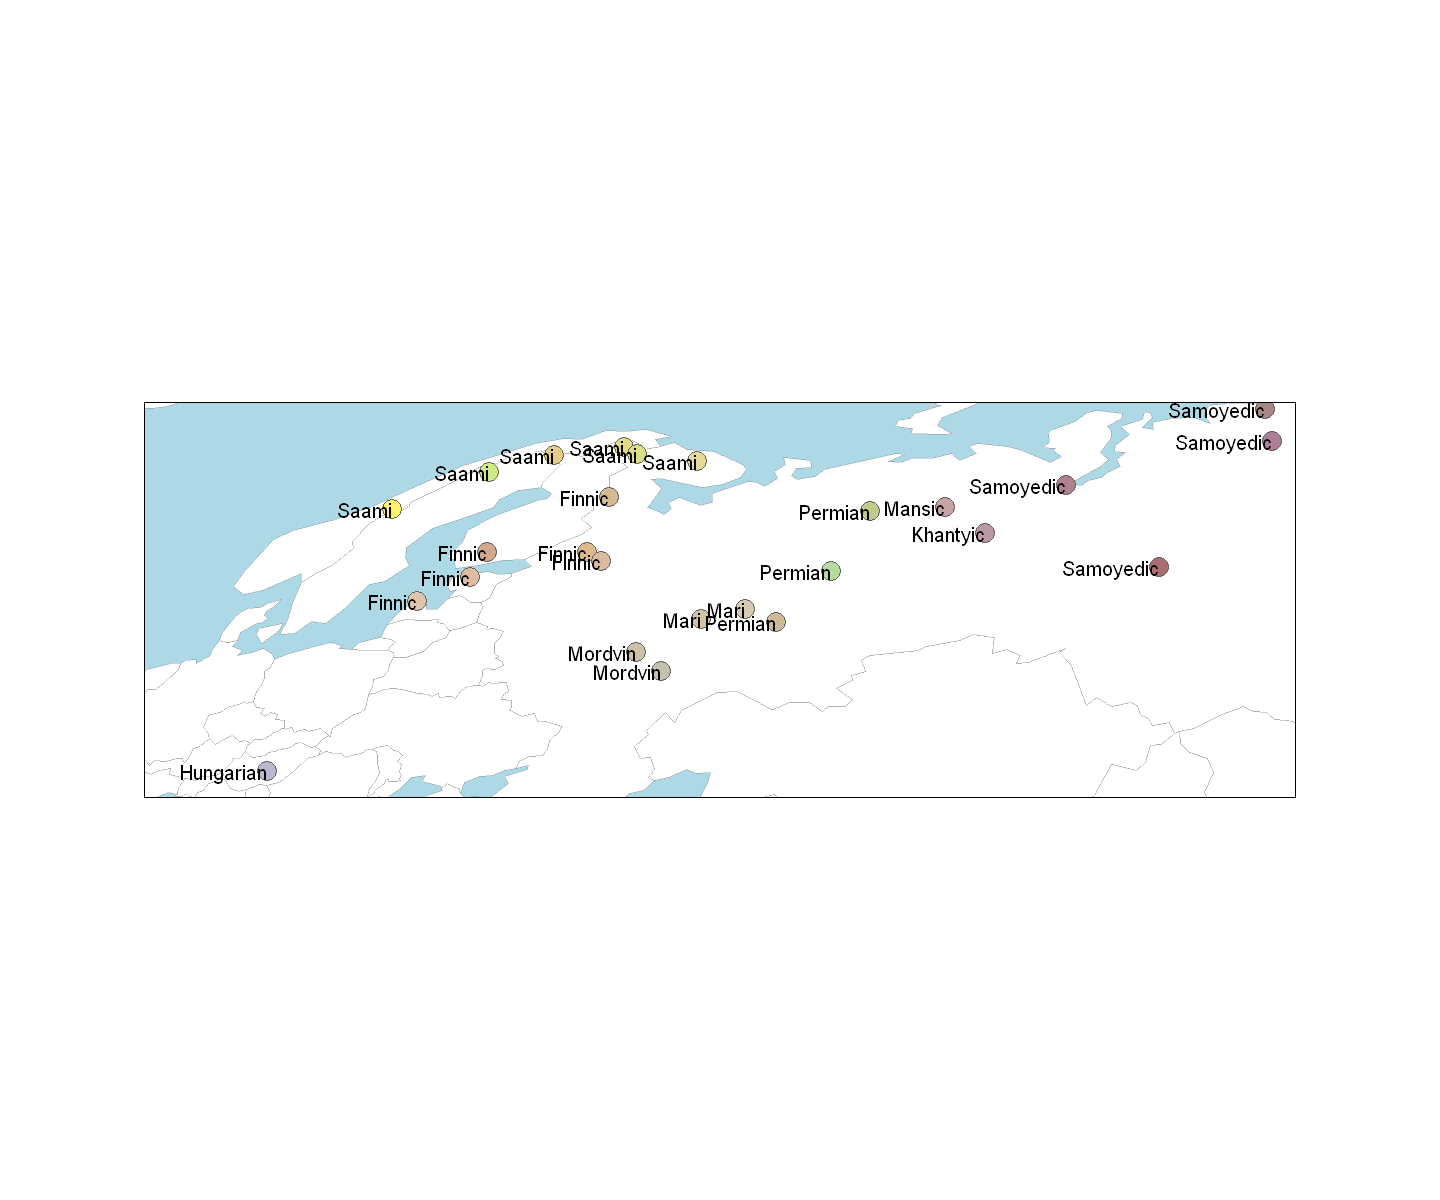

In [6]:
geodata_uralic = geodata_sf %>% filter(family == "Uralic")

bbox_new = st_bbox(geodata_uralic)
xrange = bbox_new$xmax - bbox_new$xmin
yrange = bbox_new$ymax - bbox_new$ymin

bbox_new[1] <- bbox_new[1] - (0.1 * xrange) # xmin - left
# bbox_new[3] <- bbox_new[3] + (0.1 * xrange) # xmax - right
bbox_new[2] <- bbox_new[2] - (0.05 * yrange) # ymin - bottom
# bbox_new[4] <- bbox_new[4] + (0.1 * yrange) # ymax - top

bbox_new = bbox_new %>%
  st_as_sfc()

geodata_uralic %>%
  tm_shape(bbox = bbox_new) +
  tm_symbols(size=0.2) +
  tm_shape(world_without_55) +
  tm_polygons(alpha = 1, col = 'white', border.alpha = 0.3) +
  tm_layout(bg.color = 'lightblue') +
  tm_shape(geodata_uralic) +
  tm_symbols(size=1.2, col="col", border.lwd=1, alpha=1) +
  tm_text('subfamily', size = 1, just = 'right')